In [1]:
from __future__ import print_function
from __future__ import absolute_import

import os
import sys
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

%matplotlib inline

In [2]:
# Import the LeNet5 model from the DLTK models
from dltk.models.classification.lenet import LeNet5

# Set the CUDA_VISIBLE_DEVICES environmental variable to GPU ids to compute on
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Create a save path for log files and model parameters
save_path =  '/tmp/MNIST_LeNet5'
os.system("rm -rf " + save_path)
tf.logging.set_verbosity(tf.logging.ERROR)

# Load the MNIST data via tf.examples
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../../data/MNIST_data', one_hot=False)

Extracting ../../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Build the LeNet5 network graph
net = LeNet5(num_classes=10)

# Create placeholders to feed input data during execution
xp = tf.placeholder(tf.float32, shape=[None, 784])
yp = tf.placeholder(tf.int32, shape=[None, ])

# Reshape the input images x_in from [None, 784] to [None, 28, 28, 1], where the tensor dimensions are [batch_size,x,y,channels]
x_in = tf.reshape(xp, [-1, 28, 28, 1])

# Compute the mean categorical crossentropy as a loss function
logits_ = net(x_in)['logits']
labels_ = yp
crossentropy_ = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_, labels=labels_)
loss_ = tf.reduce_mean(crossentropy_, name='crossentropy')

# Employ an ADAM optimiser to minimise the crossentropy loss during training
train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_)

[None, 4, 4, 32]
[None, 512]


In [4]:
# Create additional ops to visualise the network output and track the training steps
y_hat_ = net(x_in, is_training=False)['y_']
val_acc_ = tf.reduce_mean(tf.cast(tf.equal(tf.cast(yp, tf.int32), tf.cast(y_hat_, tf.int32)), tf.float32))
global_step = tf.Variable(0, name='global_step', trainable=False)

[None, 4, 4, 32]
[None, 512]


In [ ]:
# Set up a supervisor to continuously save and log the training progress, handle queues and initialise variables 
step = 0
loss_moving = []  
acc_moving = []  
sv = tf.train.Supervisor(logdir=save_path,
                         is_chief=True,
                         summary_op=None,
                         save_summaries_secs=30,
                         save_model_secs=60,
                         global_step=global_step)

s = sv.prepare_or_wait_for_session(config=tf.ConfigProto())

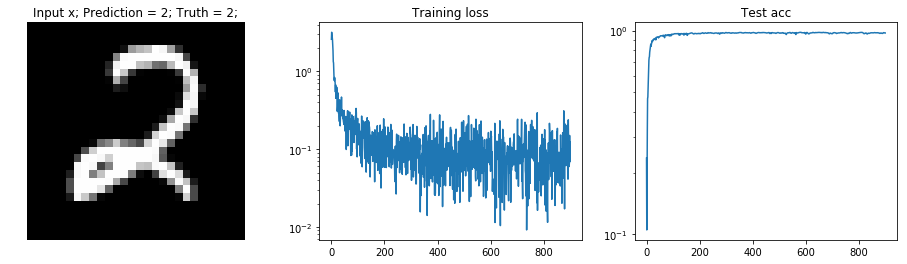

In [ ]:
# Training loop  
while not sv.should_stop():
    
    # Get a batch of training input pairs of x (image) and y (label)
    batch = mnist.train.next_batch(100)
    
    # Run the training op and the loss
    _, logits, loss = s.run([train_op, logits_, loss_], feed_dict={xp: batch[0], yp: batch[1]})
    loss_moving.append(loss)    
        
    # Compute the validation accuracy
    val_acc = s.run(val_acc_, feed_dict={xp: mnist.test.images, yp: mnist.test.labels})
    acc_moving.append(val_acc)
    
    # Visualise all inputs, outputs and losses during each training step
    if step % 20 == 0:
        plt.close()
        f, axarr = plt.subplots(1, 3, figsize=(16,4))
        
        axarr[0].imshow(np.reshape(batch[0], [-1, 28, 28])[-1], cmap='gray', vmin=0, vmax=1)
        axarr[0].set_title('Input x; Prediction = {}; Truth = {};'.format(np.argmax(logits[-1,]), batch[1][-1,]))
        axarr[0].axis('off')
        
        axarr[1].semilogy(loss_moving)
        axarr[1].set_title('Training loss')
        axarr[1].axis('on')
        
        axarr[2].semilogy(acc_moving)
        axarr[2].set_title('Test acc')
        axarr[2].axis('on')

        display.clear_output(wait=True)
        display.display(plt.gcf())

    step += 1